In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.data_reader import DataReader
from utilities.mapping import Mapper
from distance.EuclideanDistance import EuclideanDistance
from metrics.Product import Product
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics
from livelossplot import PlotLossesKeras

# Hyperparameters

In [11]:
image_size = (224, 224)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 50
validation_triplets = 10
training_path = r".\data\FruitRecognition\Training"
validation_path = r".\data\FruitRecognition\Validation"

# Creating training dataset from generator 

In [12]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [13]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(224, 224, 3)


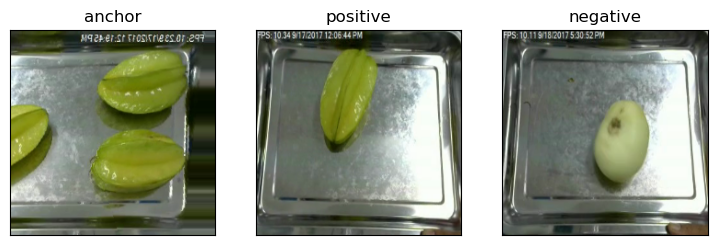

In [14]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

[[[0.4702794  0.31162342 0.16894259]
  [0.5258016  0.33726868 0.16942778]
  [0.5719663  0.3868235  0.17975692]
  ...
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]]

 [[0.47675073 0.30327258 0.17765732]
  [0.53469265 0.34342864 0.18726993]
  [0.59171045 0.39296472 0.19175422]
  ...
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]]

 [[0.5126776  0.33984846 0.20367898]
  [0.5610582  0.3728229  0.20892234]
  [0.62059575 0.40952635 0.21784717]
  ...
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]
  [0.18431373 0.23529413 0.21568629]]

 ...

 [[0.11232494 0.15602241 0.13165267]
  [0.11904763 0.15042017 0.1229692 ]
  [0.11764707 0.14901961 0.12156864]
  ...
  [0.38445354 0.44273445 0.4554446 ]
  [0.4039216  0.45639005 0.46125707]
  [0.4039216  0.45639005 0.46125707]]

 [[0.11232494 0.15602241 0.13165267]
  [0.11904763 0.15042017 0.1229692 ]


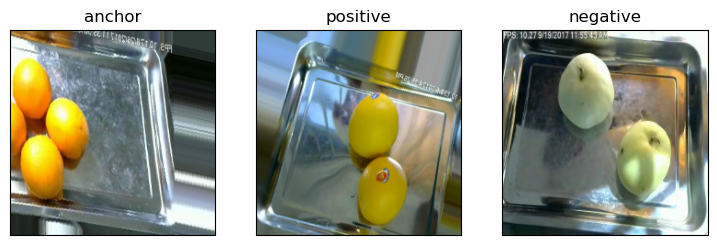

In [30]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Load model (Transfer learning)

In [16]:
from keras.src.applications.vgg16 import VGG16
modelVGG = VGG16(weights='imagenet', include_top=False)

# Creating siamese model

In [17]:
input_layer = keras.layers.Input(image_size + (3,))
x = modelVGG(input_layer)
# x = keras.layers.BatchNormalization()(input_layer)
# x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Flatten()(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(10, activation="tanh")(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda param: tf.math.l2_normalize(param, axis=1))(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [18]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Freezing weights on trained layers

In [19]:
for layer in modelVGG.layers:
    layer.trainable = False

# Creating callbacks

In [32]:
# Wartosc parametru patience musi byc dostosowana do ilosci epok
# Moja estymata to n_epok >= patience * 2
monitor_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) 
# Wartosc patience musi byc mniejsza niz w EarlyStopping
# gdyz najpierw chcemy przetestowac zmiane learning rate w kolejnych epokach
# a dopiero wtedy przerwac trening jesli nie dalo to efektow
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                         factor=0.1,
                                                         patience=10,
                                                         min_lr=0.001)

# Compilation of our model and summary

In [21]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001), metrics=['accuracy'])
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_7 (Functional)       │ ?                      │    16,321,680 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321,680 (62.26 MB)

 Trainable params: 1,606,864 (6.13 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

# Training 

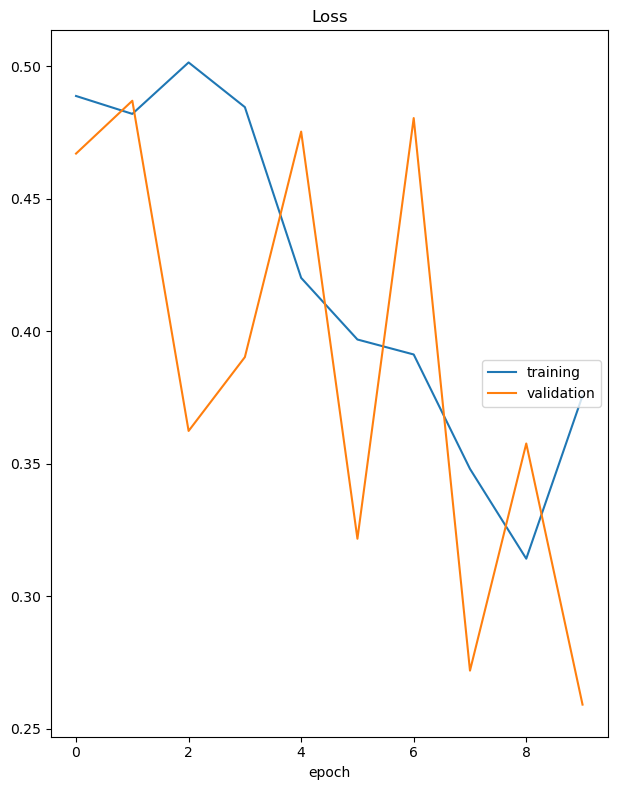

Loss
	training         	 (min:    0.314, max:    0.501, cur:    0.376)
	validation       	 (min:    0.259, max:    0.487, cur:    0.259)
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - loss: 0.3519 - val_loss: 0.2591


In [22]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset, callbacks=[PlotLossesKeras(), monitor_val_loss])

# Saving trained model weights

In [23]:
# siamese_network.save_weights('trained_models/VGG16_plus_dense_64_16_triplet.weights.h5')

# Loading all the representatives of product types 

In [24]:
path = r".\data\products"
products_paths = DataReader.read_types_of_products(path)
products_dictionary = DataReader.generate_images_classes_dict(products_paths)
k, v = products_dictionary.items().__iter__().__next__()
print(k)
print(v)

.\data\products\Apple A
['.\\data\\products\\Apple A\\Apple 51.png']


# Mapping representatives and parsing into Product objects

In [25]:
representatives = []
mapper = Mapper(image_size)
for label, product in products_dictionary.items():
    rep = Product()
    rep.label, rep.image = mapper.map_single_product(label, product[0])
    rep.label = rep.label.rsplit('\\', 1)[1]
    rep.image_path = product[0]
    representatives.append(rep)
print(representatives[0].label, representatives[0].image_path, representatives[0].image)

Apple A .\data\products\Apple A\Apple 51.png tf.Tensor(
[[[0.24007355 0.2844363  0.27928922]
  [0.21607144 0.28667718 0.26043418]
  [0.23965338 0.27053574 0.2626926 ]
  ...
  [0.10012256 0.15502451 0.1079657 ]
  [0.10171571 0.15661767 0.12071081]
  [0.09268215 0.14721647 0.11192236]]

 [[0.23207285 0.28485647 0.27533266]
  [0.21642159 0.28492647 0.30490196]
  [0.22377452 0.27463236 0.2719363 ]
  ...
  [0.07223394 0.1271359  0.08044471]
  [0.05448194 0.10938391 0.07312689]
  [0.03061987 0.08494412 0.04854709]]

 [[0.22711836 0.27589288 0.2654237 ]
  [0.31412816 0.39879203 0.46903014]
  [0.7046044  0.75582993 0.7145133 ]
  ...
  [0.01320031 0.06694682 0.02062328]
  [0.         0.04690133 0.01218494]
  [0.         0.03214291 0.        ]]

 ...

 [[0.1329657  0.06311275 0.03602941]
  [0.13016458 0.06031163 0.03322829]
  [0.13177522 0.06192227 0.03378852]
  ...
  [0.09324232 0.14334737 0.15206584]
  [0.09019608 0.13725491 0.14901961]
  [0.09187671 0.14061615 0.15070024]]

 [[0.14007354 0.06

# Reshaping the images so as they would fit into out model

In [26]:
for r in representatives:
    r.image = tf.reshape(r.image, shape=(1,) + image_size + (3,))
    
print(representatives[0].image)

tf.Tensor(
[[[[0.24007355 0.2844363  0.27928922]
   [0.21607144 0.28667718 0.26043418]
   [0.23965338 0.27053574 0.2626926 ]
   ...
   [0.10012256 0.15502451 0.1079657 ]
   [0.10171571 0.15661767 0.12071081]
   [0.09268215 0.14721647 0.11192236]]

  [[0.23207285 0.28485647 0.27533266]
   [0.21642159 0.28492647 0.30490196]
   [0.22377452 0.27463236 0.2719363 ]
   ...
   [0.07223394 0.1271359  0.08044471]
   [0.05448194 0.10938391 0.07312689]
   [0.03061987 0.08494412 0.04854709]]

  [[0.22711836 0.27589288 0.2654237 ]
   [0.31412816 0.39879203 0.46903014]
   [0.7046044  0.75582993 0.7145133 ]
   ...
   [0.01320031 0.06694682 0.02062328]
   [0.         0.04690133 0.01218494]
   [0.         0.03214291 0.        ]]

  ...

  [[0.1329657  0.06311275 0.03602941]
   [0.13016458 0.06031163 0.03322829]
   [0.13177522 0.06192227 0.03378852]
   ...
   [0.09324232 0.14334737 0.15206584]
   [0.09019608 0.13725491 0.14901961]
   [0.09187671 0.14061615 0.15070024]]

  [[0.14007354 0.06409314 0.037990

# Evaluating embeddings for all representatives

In [27]:
for r in representatives:
    r.embedding = np.asarray(embedding_model(r.image)).astype('float32')
print(representatives[0].embedding)

[[0.01452769 0.13107704 0.29954448 0.38591185 0.2595364  0.
  0.         0.20154418 0.09435569 0.         0.19143598 0.319084
  0.53477514 0.3844719  0.23410553 0.        ]]


# Creating a generator for test images

In [28]:
test_path = r".\data\FruitRecognition\Test"
test_generator = TestProductsGenerator(test_path)

# Calculating the overall efficiency of the model based on the testing dataset 

In [29]:
efficiency_sum = 0
test_length = 0
mapper = Mapper(image_size)

# for l, p in test_generator.get_next_element():
for i in range(1000):
    l, p = next(iter(test_generator.get_next_element()))
    label, image = mapper.map_single_product(l, p)
    label = label.rsplit('\\', 1)[1]
    image_path = p
    image = tf.reshape(image, shape=(1,) + image_size + (3,))
    embedding = np.asarray(embedding_model(image)).astype('float32')
    distances = np.zeros(len(representatives))
    labels = []
    for i in range(len(representatives)):
        distances[i] = EuclideanDistance.calculate_distance((embedding, representatives[i].embedding))
        labels.append(representatives[i].label)
    top5_dist, top5_labels = Metrics.find_top_5(distances,labels)
    efficiency_sum += Metrics.calculate_efficiency(label, top5_labels) 
    test_length += 1
overall_efficiency = efficiency_sum / test_length
print(overall_efficiency)
print(test_length)

1.0
1000
